# Objective

<hr>

### Predict total sales for every product and store in the next month.

This looks like a time series problem, and I'll try to tackle it using LSTM/GRU. Since it has almost 3 millions rows of data, deep learning seems feasible

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [166]:
df_train = pd.read_csv("sales_train_v2.csv")
df_test = pd.read_csv("test.csv")
# df_shopname = pd.read_csv("shops.csv") The name of the shop is not needed, as they are already label encoded
# df_item_cat = pd.read_csv("item_categories.csv") Name of the categories are not needed too
df_items = pd.read_csv("items.csv")
df_submit = pd.read_csv("sample_submission.csv")

### Mapping the item categories to the item ids

In [3]:
item_dict = df_items[['item_id','item_category_id']].to_dict()
df_train['item_cat_id'] = pd.Series()
df_train['item_cat_id'] = df_train['item_id'].apply(lambda x : item_dict['item_category_id'][x])

## Quick data analysis
<hr>

In [56]:
len(df_train)
len(df_test)

2935849

214200

In [5]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cat_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


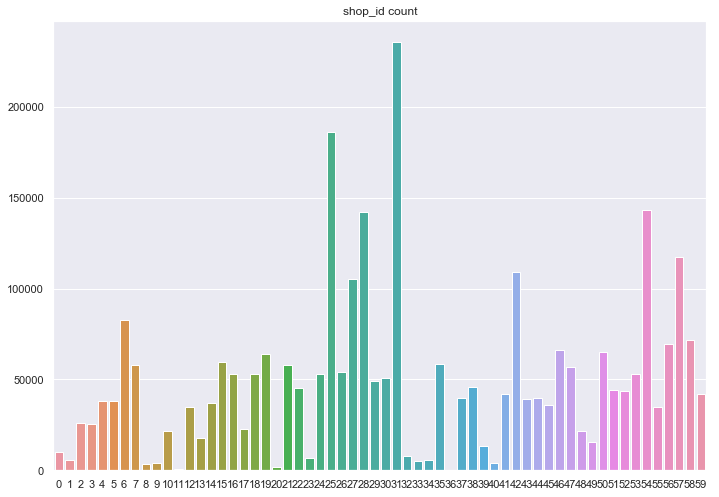

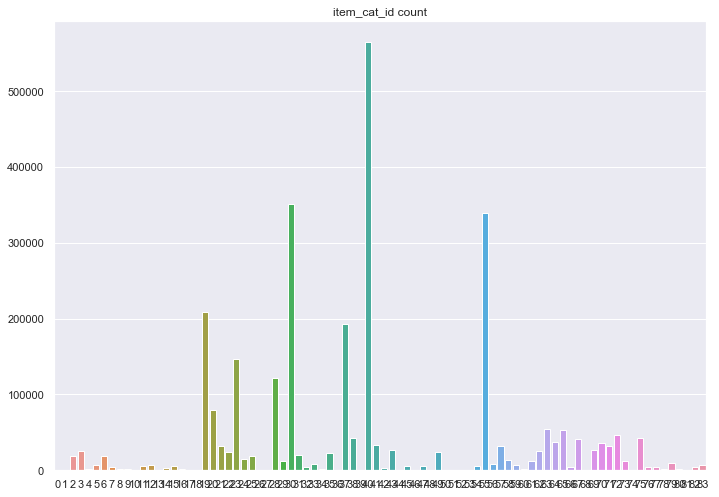

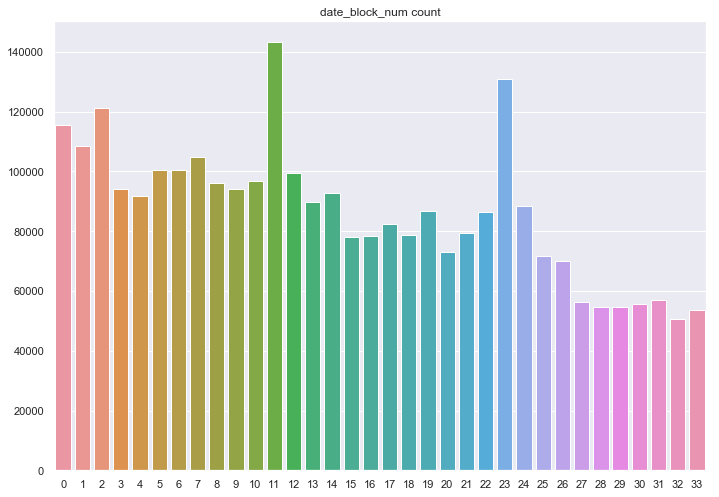

In [26]:
items = ['shop_id', 'item_cat_id', 'date_block_num']

for item in items:
    item_counts = df_train[item].value_counts()
    sns.barplot(item_counts.index, item_counts.values)
    plt.title(item+' count')
    plt.show()

#### Months 11 and 23, which are year end months, have a lot of sales

In [27]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cat_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


#### Needs data cleaning to remove negative values in item price, and item counts per day. Their count values are small enough for us to remove them

In [38]:
df_train[df_train['item_price'] < 0].count()

date              1
date_block_num    1
shop_id           1
item_id           1
item_price        1
item_cnt_day      1
dtype: int64

In [39]:
df_train[df_train['item_cnt_day'] < 0].count()

date              7356
date_block_num    7356
shop_id           7356
item_id           7356
item_price        7356
item_cnt_day      7356
dtype: int64

# Data Cleaning
<hr>

#### Removing negative item price and counts

In [40]:
df_train = df_train[(df_train['item_price'] > 0) & (df_train['item_cnt_day'] > 0)]

# Modeling it as a sequence problem
<hr>

In [132]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### Transforming the data to get item sale count at every month for each shop

In [172]:
dataset = df_train.pivot_table(index=['item_id','shop_id'], columns=['date_block_num'], values=['item_cnt_day'], fill_value=0)

In [175]:
dataset.head()

item_cnt_day                                               \
date_block_num            0    1    2    3    4    5    6    7    8    9    
item_id shop_id                                                             
0       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       55               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                ...                                                     
date_block_num  ...    24   25   26   27   28   29   30   31   32   33  
item_id shop_id ...                                                     
0       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       55      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

#### Merging with test data to only get those item_id and shop_id in the test set

In [185]:

dataset_filtered = pd.merge(df_test, dataset, on=['item_id', 'shop_id'], how='left')
dataset_filtered.fillna(0, inplace=True)

In [186]:
dataset_filtered.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
dataset_filtered.drop(['ID', 'shop_id', 'item_id'], axis=1, inplace=True)

In [197]:
X_train = np.expand_dims(dataset_filtered.values[:, :-1], axis=2) # all rows except the last column
y_train = dataset_filtered.values[:, -1:] # last column will be our target value

X_test = np.expand_dims(dataset_filtered.values[:, 1:], axis=2) # shifitng the days by 1, to do a predicting on n+1

In [231]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True,input_shape=(33,1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 33, 128)           66560     
_________________________________________________________________
dropout_27 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 33, 64)            49408     
_________________________________________________________________
lstm_50 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 149,057
Trainable params: 149,057
Non-trainable params: 0
_________________________________________________________________


In [232]:
reg = model.fit(X_train, y_train, batch_size=1024, epochs=10)

Epoch 1/10
214200/214200 [==============================] - 36s 168us/step - loss: 1.3661 - mean_squared_error: 1.3661
Epoch 2/10
214200/214200 [==============================] - 33s 154us/step - loss: 1.3514 - mean_squared_error: 1.3514
Epoch 3/10
214200/214200 [==============================] - 34s 161us/step - loss: 1.3603 - mean_squared_error: 1.3603
Epoch 4/10
214200/214200 [==============================] - 35s 163us/step - loss: 1.3531 - mean_squared_error: 1.3531
Epoch 5/10
214200/214200 [==============================] - 33s 153us/step - loss: 1.3518 - mean_squared_error: 1.3518
Epoch 6/10
214200/214200 [==============================] - 32s 151us/step - loss: 1.3225 - mean_squared_error: 1.3225
Epoch 7/10
214200/214200 [==============================] - 34s 157us/step - loss: 1.3161 - mean_squared_error: 1.3161
Epoch 8/10
214200/214200 [==============================] - 33s 153us/step - loss: 1.3136 - mean_squared_error: 1.3136
Epoch 9/10
214200/214200 [======================

In [233]:
LSTM_prediction = model.predict(X_test)

In [239]:
submission = pd.DataFrame({'ID': df_test['ID'], 'item_cnt_month': LSTM_prediction.ravel()})
submission.to_csv('submission.csv',index=False)

In [240]:
len(LSTM_prediction)

214200